# Importing libraries

In [ ]:
import os
import numpy as np
np.set_printoptions(suppress=True)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image


from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import SGD




# Importing the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# reading csv
dataset = pd.read_csv(r'/content/drive/MyDrive/Projet/daily/data/dataset_btc.csv',sep=',' )
dataset=dataset[:]

In [ ]:
print(dataset.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volubtc', 'voluusdt',
       'tradecount', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'chikou_span', 'MACD', 'MA_window_10', 'MA_window_20',
       'Day_dif', 'Close_off_high', 'Volatility', 'avg-block-size',
       'n-transactions-per-block', 'transaction-fees', 'cost-per-transaction',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_fb',
       'open_tesla', 'open_apple', 'fng_value'],
      dtype='object')



# Parameter settings

In [ ]:
dataset=dataset[1008:]

#Market
dataset = dataset.drop('open', 1)
dataset = dataset.drop('high', 1)
dataset = dataset.drop('low', 1)
dataset = dataset.drop('voluusdt', 1)
dataset = dataset.drop('volubtc', 1)
dataset = dataset.drop('tradecount', 1)
#Social

dataset = dataset.drop('TrendGoogle', 1)

#Blochain

dataset = dataset.drop('miners-revenue', 1)
dataset = dataset.drop('transaction-fees', 1)
dataset = dataset.drop('avg-block-size', 1)
dataset = dataset.drop('n-transactions-per-block', 1)
dataset = dataset.drop('cost-per-transaction', 1)

#Economy
dataset = dataset.drop('open_microsoft', 1)
dataset = dataset.drop('open_apple', 1)
dataset = dataset.drop('open_tesla', 1)

dataset = dataset.drop('open_fb', 1)
#Indic

dataset = dataset.drop('senkou_span_b', 1)
dataset = dataset.drop('tenkan_sen', 1)
dataset = dataset.drop('kijun_sen', 1)
dataset = dataset.drop('senkou_span_a', 1)
dataset = dataset.drop('chikou_span', 1)

dataset = dataset.drop('MACD', 1)
dataset = dataset.drop('MA_window_10', 1)
dataset = dataset.drop('MA_window_20', 1)

dataset = dataset.drop('fng_value', 1)

#More

dataset = dataset.drop('Day_dif', 1)
dataset = dataset.drop('Close_off_high', 1)
dataset = dataset.drop('Volatility', 1)











print(dataset.columns)

Index(['date', 'close'], dtype='object')


In [ ]:


# number of total past observations from the original dataset to be considered
n_past_total =310

# number of past observations to be considered for the LSTM training and prediction
n_past = 30

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 30

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 5

# number of neurons of the hidden layers
n_neurons = 64

# patience for the early stopping (number of epochs)
patience = 5

# optimizer (adam, RMSprop)
# lr=0.02
# momentum=0.9
optimizer='adam'##SGD(lr=lr, momentum=momentum)

# batch size
batch_size=1

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
'''features = [   'open', 'high', 'low', 'close', 'volubtc', 'voluusdt',
       'tradecount']'''
features = ['close']

# number of inputs features (if higher than 1, )
n_features = len(features)


# EDA (brief)

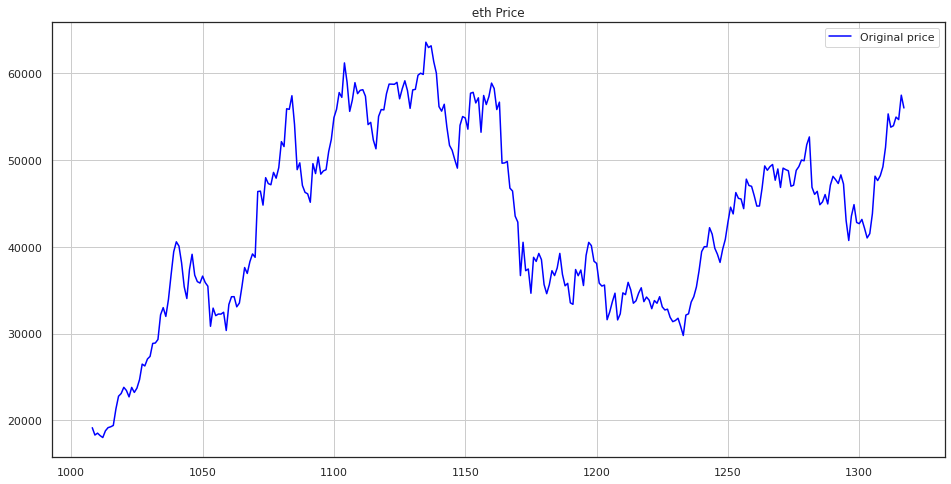

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(dataset["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    310 non-null    object 
 1   close   310 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [ ]:
# checking the main parameters
dataset.describe()

,close
count,310.000
mean,43084.095
std,10618.390
min,18036.530
25%,34786.505
50%,43809.235
75%,51251.620
max,63575.000


In [ ]:
# use close only and fill NaN with ffil
df = dataset.set_index('date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)


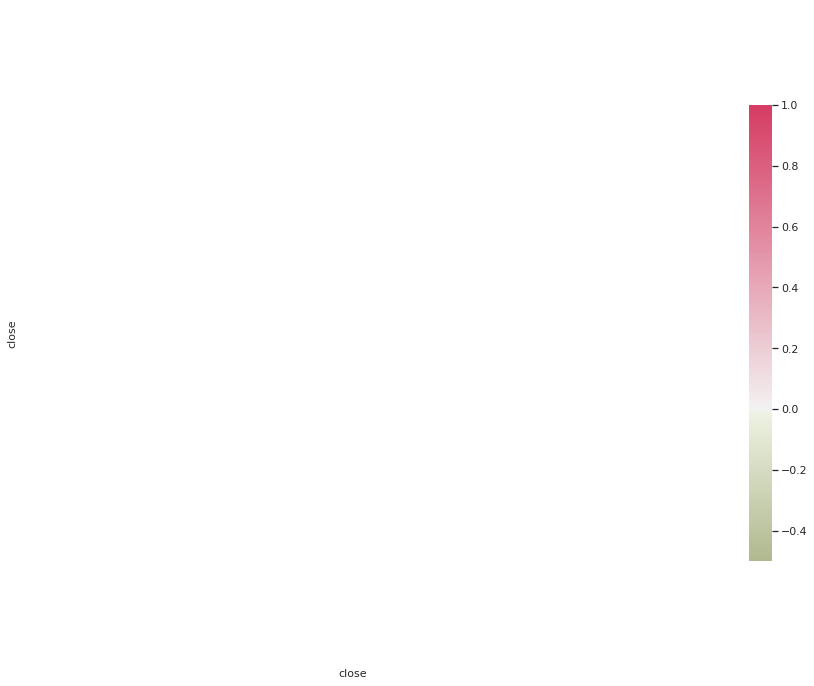

In [ ]:
# looking at the correlation of the main possible variables
import matplotlib.pyplot as plt
import seaborn as sns



sns.set_theme(style="white")




# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(98, 2, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-0.5, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .7},annot=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    310 non-null    object 
 1   close   310 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB



# Preprocessing the data

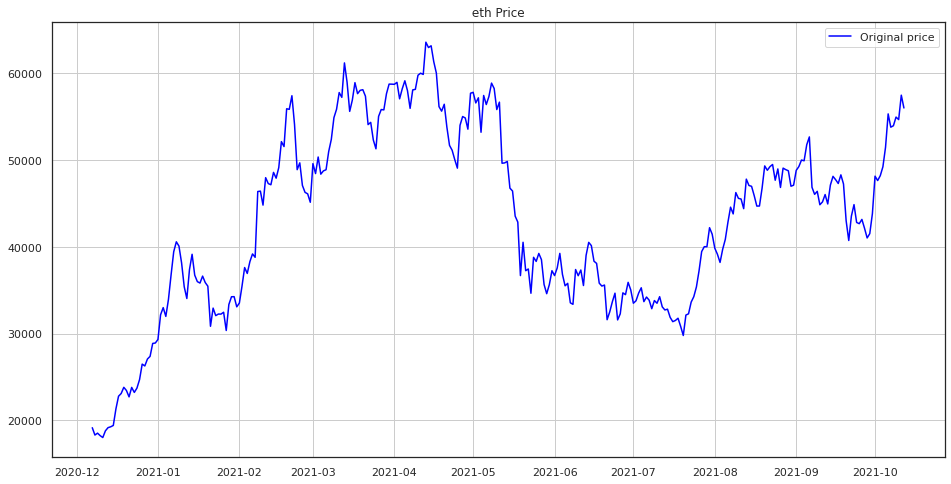

In [ ]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(df["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
# train test split
training_set = df
training_set = training_set.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (310, 1)


In [ ]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape:  (310, 1)


array([[0.02482231],
       [0.0063151 ],
       [0.01108404],
       [0.00478936],
       [0.        ],
       [0.01695621],
       [0.02499996],
       [0.02715528],
       [0.03052145],
       [0.07244402],
       [0.10454084],
       [0.11135332],
       [0.12703721],
       [0.11899807],
       [0.10284008],
       [0.1267996 ],
       [0.11410638],
       [0.12500793],
       [0.14660001],
       [0.18570804],
       [0.18105856],
       [0.19857672],
       [0.20528731],
       [0.23801876],
       [0.23907479],
       [0.24803556],
       [0.31054623],
       [0.32859075],
       [0.30638227],
       [0.34944081],
       [0.41136274],
       [0.46983902],
       [0.49510403],
       [0.4842431 ],
       [0.44168129],
       [0.3813905 ],
       [0.35167431],
       [0.42458278],
       [0.46351953],
       [0.41076676],
       [0.39435778],
       [0.39070439],
       [0.40833036],
       [0.3920852 ],
       [0.38279064],
       [0.28137968],
       [0.32738561],
       [0.308

In [ ]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

X_test = X_train[-1].reshape(1, n_past, n_features)
y_test  = y_train[-1]



In [ ]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape



(251, 30, 1)

# BUILD LSTM

In [ ]:
# Building the RNN

# Initialising the RNN
regressor = Sequential()

# Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

# Hidden layers
for _ in range(n_layers):
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

# Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False))

# Adding the output layer
regressor.add(Dense(units=n_future,))

# Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
)


# Model summary
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 30)            3840      
                                                                 
 dropout_16 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_19 (LSTM)              (None, 30, 64)            24320     
                                                                 
 dropout_17 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_20 (LSTM)              (None, 30, 64)            33024     
                                                                 
 dropout_18 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 30, 64)           

In [ ]:
#  Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [ ]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=batch_size
                    , epochs=10
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   )



Epoch 1/10
225/225 [==============================] - 23s 71ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2/10
225/225 [==============================] - 14s 64ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 3/10
225/225 [==============================] - 16s 69ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 4/10
225/225 [==============================] - 15s 68ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/10
225/225 [==============================] - 14s 62ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 6/10
225/225 [==============================] - 14s 61ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 7/10
225/2

In [ ]:
# Exporting the regressor
last_date = dataset.date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons,batch_size ,n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [ ]:
list(res.history)

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']

In [ ]:
# Loads the weights
#regressor.load_weights(checkpoint_path)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('C:\Users\yonas\output\reg_2021-10-29_700_90_7_softsign_6_64_5_19_25_adam\regressor.h5')


# GridSearch


In [ ]:


#### Batch Size
batch_size1 = [ 1,7,14,30]


# Optimizer: Select!
#### Optimizer
optimizer1 = ['Adam', 'Adamax'] #'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'


#### Neuron Activation Function
activation1 = ['relu', 'softmax','softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] #'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'

#### Tune Dropout Regularization

dropout1 = [0.0, 0.1, 0.2, 0.3] #0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

#### Tune the Number of Neurons in the Hidden Layer
n_neurons1 = [100, 200] #10, 50, 100, 200

n_past1=[10,20,30,40]
# number of hidden layers
n_layers1 = [3, 5,6]


In [ ]:
'''
# define the grid search parameters


scoring='mean_absolute_error'
param_grid = dict(dropout=dropout1, n_neurons=n_neurons1, n_layers=n_layers1, batch_size=batch_size1,n_past=n_past1)
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\n# define the grid search parameters\n\n\nscoring=\'mean_absolute_error\'\nparam_grid = dict(dropout=dropout1, n_neurons=n_neurons1, n_layers=n_layers1, batch_size=batch_size1,n_past=n_past1)\ngrid = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X_train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n'


# Validation

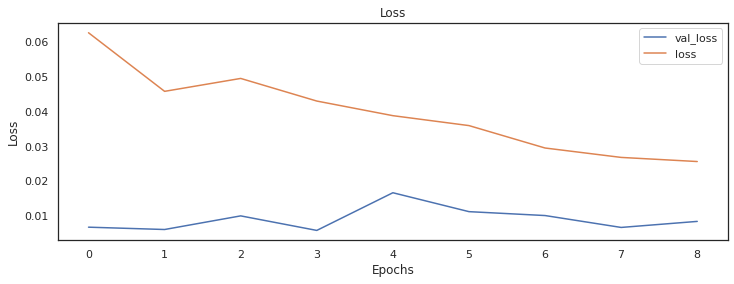

In [ ]:


# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()



In [ ]:


def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y



y_pred:
 [[46265.162009921674], [46791.9080507195], [46665.519183992146], [47050.29082261145], [46248.01303517759], [46235.51366374731], [45404.784538347725], [46022.894062824846], [45618.42743200183], [44968.37054558456], [45292.58605464697], [45846.90942741692], [45225.42602266014], [45378.55892993093], [45353.9320467633], [45763.47442667961], [45483.50750677168], [45773.76706869125], [45549.35924407244], [45525.11779211938], [44938.290625022055], [45388.536712640525], [44353.05404026091], [45576.11414183319], [44359.86965842843], [44137.112130841015], [43315.69578359067], [42064.811348352436], [42134.88382888317], [42127.883638021354]]
y_true:
 [[44940.73], [47111.52], [48121.41], [47737.82], [47299.98], [48292.74], [47241.75], [43015.62], [40734.38], [43543.61], [44865.26], [42810.57], [42670.64], [43160.9], [42147.35], [41026.54], [41524.28], [43824.1], [48141.61], [47634.9], [48200.01], [49224.94], [51471.99], [55315.0], [53785.22], [53951.43], [54949.72], [54659.0], [57471.35], 

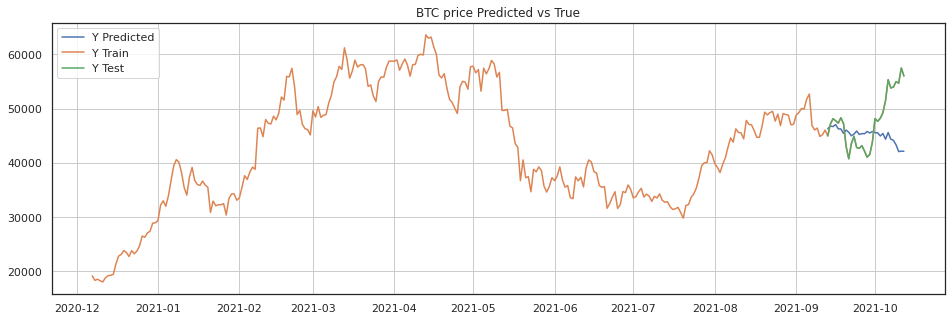

In [ ]:


# Validation

# getting the predictions
y_pred = regressor.predict(X_test).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#.tail(n_future)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())


# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Y Predicted')
plt.plot(y_true_df, label='Y Train')
plt.plot(y_true_df.tail(n_past), label='Y Test')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.grid()
plt.show()



In [ ]:
listetrue = y_true.tolist()
listepred = y_pred.tolist()

In [ ]:
listetrue = np.array(listetrue).reshape(30,1)
listepred = np.array(listepred).reshape(30,1)
print('true',str(np.shape(listetrue)))
print('pred',str(np.shape(listepred)))

true (30, 1)
pred (30, 1)


In [ ]:

# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(listepred, listetrue))
moy = y_true.mean()
Nrmse = rmse/moy
Nrmse


0.13314619682493958

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


Mape= mape(listepred, listetrue)
Mape


10.694998568083415

In [ ]:


#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.



-0.41411217671808553


# Predictions

y_pred:
 [[56734.117087795734], [56299.81482379973], [56169.872932707076], [55477.25846873164], [54303.123702670935], [53678.58670554519], [53766.29130699039], [52945.835823472145], [53661.19887202024], [52150.68037059486], [52238.81654642821], [52772.61163556576], [51745.11173221469], [52213.57894478679], [52180.66257620156], [51816.18579104245], [50776.30323134721], [51826.59786244452], [51366.097133075], [51143.54860692084], [50679.402566838864], [50429.067707279326], [50295.81707921088], [50453.29287340641], [49815.219640597104], [48578.41701621235], [48187.71733694077], [46987.736965069176], [46745.2600165391], [46309.35902729392]]
y_true:
 [[44940.73], [47111.52], [48121.41], [47737.82], [47299.98], [48292.74], [47241.75], [43015.62], [40734.38], [43543.61], [44865.26], [42810.57], [42670.64], [43160.9], [42147.35], [41026.54], [41524.28], [43824.1], [48141.61], [47634.9], [48200.01], [49224.94], [51471.99], [55315.0], [53785.22], [53951.43], [54949.72], [54659.0], [57471.35], [5

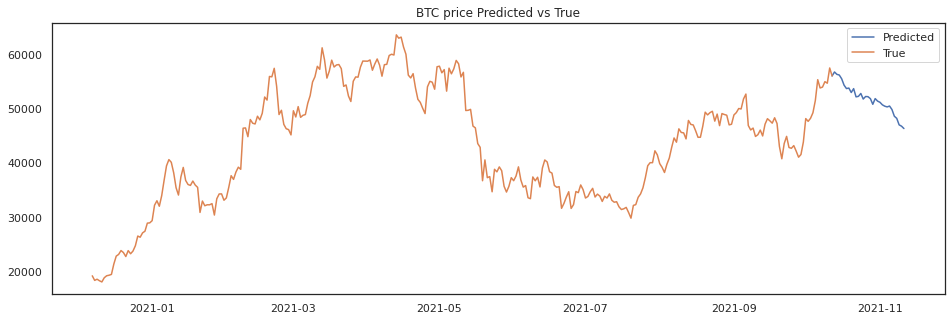

In [ ]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

In [ ]:
# export to csv
#y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

,close
2021-10-12,55996.930
2021-10-13,56734.117
2021-10-14,56299.815
2021-10-15,56169.873
2021-10-16,55477.258
2021-10-17,54303.124
2021-10-18,53678.587
2021-10-19,53766.291
2021-10-20,52945.836
2021-10-21,53661.199


# cross validation

In [ ]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from keras.models import Sequential
from keras.layers import Activation, Dense,Flatten,LSTM,Dropout

In [ ]:
y_pred60scores = regressor.evaluate(X_test, df[['close']].tail(n_future), verbose=0)

ValueError: ignored

In [ ]:
cvscores = []
for train, test in kfold.split(x,y):
  print("%s: %.2f%%" % (regressor.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

  
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# SHAP

https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
import shap

In [ ]:
e = shap.DeepExplainer((regressor.layers[0].input, regressor.layers[-1].output),X_train)
test1 = X_test
shap_val = e.shap_values(test1)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
f_names = features
x_pos = [i for i, _ in enumerate(f_names)]
plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Yesterday’s features (time-step 2)")
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title(" day before yesterday’s features(time-step 1)")
plt.tight_layout()
plt.show()